In [12]:
!pip freeze > requirements.txt

## Problema de negócio
Medições do consumo de energia elétrica em uma residência com taxa de amostragem de um minuto durante um período de quase 4 anos. Diferentes grandezas elétricas e alguns valores de submedição estão disponíveis.

### Arquitetura dos dados
* **1.date:** Data no formato dd/mm/aaaa
* **2.time:** hora no formato hh:mm:ss
* **3.global_active_power:** potência ativa média global doméstica por minuto (em quilowatts)
* **4.global_reactive_power:** potência reativa média global doméstica por minuto (em quilowatts)
* **5.voltage:** tensão média por minuto (em volts)
* **6.global_intensity:** intensidade de corrente média global por minuto doméstica (em amperes)
* **7.sub_metering_1:** submedição de energia nº 1 (em watt-hora de energia ativa). Corresponde à **cozinha**, contendo majoritariamente **uma máquina de lavar louça, um forno e um micro-ondas** (as placas não são elétricas mas sim a gás).
* **8.sub_metering_2:** submedição de energia nº 2 (em watt-hora de energia ativa). Corresponde à **lavandaria**, contendo **máquina de lavar roupa, máquina de secar roupa, frigorífico e luz**.
* **9.sub_metering_3:** submedição de energia nº 3 (em watt-hora de energia ativa). Corresponde a um **aquecedor elétrico e a um ar condicionado**.

In [13]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings("ignore")

In [14]:
dados = pd.read_csv("household_power_consumption.csv", sep=";", low_memory=False)

print(dados.shape)
dados.head()

(113606, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [15]:
dados.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [16]:
#dados faltantes
dados.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           8
dtype: int64

In [17]:
dados.dropna(axis='index', how='any',  inplace=True)

In [18]:
#dados duplicados
dados.duplicated().sum()

0

In [19]:
#remove as colunas desnecessárias
dados.drop(columns=['Date', 'Time'], inplace=True)

In [20]:
dados.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [21]:
#força a conversão de colunas númericas

cols = dados.columns
for col in cols:
    dados[col] = pd.to_numeric(dados[col])

dados.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [22]:
#retirar uma amostra de dados do dataset (devido a performance, milhares de linhas aumenta tempo de processamento)

dados_amostra, dados_descarte = train_test_split(dados, train_size=20000) #1% dos dados como amostra

In [23]:
dados_amostra

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
20674,0.312,0.160,244.18,1.4,0.0,0.0,0.0
72820,1.086,0.000,240.45,4.4,0.0,0.0,0.0
79249,0.404,0.134,240.45,1.8,0.0,0.0,0.0
16514,0.236,0.066,248.01,1.0,0.0,0.0,0.0
37173,0.330,0.182,242.41,1.6,0.0,0.0,0.0
...,...,...,...,...,...,...,...
84437,0.520,0.000,241.29,2.2,0.0,0.0,0.0
57316,0.228,0.000,242.48,1.0,0.0,0.0,0.0
26923,1.876,0.134,237.60,8.0,0.0,0.0,18.0
54130,2.286,0.000,239.95,9.6,0.0,0.0,0.0


In [24]:
#padronização dos dados
dados_copia = StandardScaler().fit_transform(dados_amostra)

display(dados_amostra.head())
dados_copia


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
20674,0.312,0.160,244.18,1.4,0.0,0.0,0.0
72820,1.086,0.000,240.45,4.4,0.0,0.0,0.0
79249,0.404,0.134,240.45,1.8,0.0,0.0,0.0
16514,0.236,0.066,248.01,1.0,0.0,0.0,0.0
37173,0.330,0.182,242.41,1.6,0.0,0.0,0.0


array([[-0.90458439,  0.31777498,  0.99566266, ..., -0.1842115 ,
        -0.24627136, -0.8138116 ],
       [-0.33195854, -1.07615069, -0.10749912, ..., -0.1842115 ,
        -0.24627136, -0.8138116 ],
       [-0.83652034,  0.09126206, -0.10749912, ..., -0.1842115 ,
        -0.24627136, -0.8138116 ],
       ...,
       [ 0.25250455,  0.09126206, -0.95039753, ..., -0.1842115 ,
        -0.24627136,  1.28616672],
       [ 0.5558335 , -1.07615069, -0.25537604, ..., -0.1842115 ,
        -0.24627136, -0.8138116 ],
       [-0.09669365, -0.08297865,  1.15832726, ..., -0.1842115 ,
         0.00833189,  1.28616672]])

In [70]:
#reduzir a dimensionalidade do dataset, de 7 para X features (útil em datasets com muitas features)
pca = PCA(n_components=4)
dados_pca = pca.fit_transform(X=dados_copia)
dados_pca.shape

(20000, 4)

In [26]:
dados_pca

array([[-1.66364444,  0.62953873,  0.49785197],
       [-0.93355205, -0.56961835, -0.2046775 ],
       [-1.20362384,  0.27275661,  0.27084256],
       ...,
       [ 0.99448593, -0.60374457, -0.60638784],
       [ 0.0582835 , -0.6622218 , -0.25627963],
       [-0.19471246, -0.18137998, -0.48107918]])

In [72]:
#verifica qual melhor quantidade de componentes, para explicar a maioria das variáveis
import plotly.express as px

px.bar(x=pca.get_feature_names_out(),
       y=(pca.explained_variance_ratio_ * 100),
       color=pca.get_feature_names_out(),
       text_auto=True, height=350, width=600,
       labels={'x' : f'Component: {pca.explained_variance_ratio_.sum()*100:.2f}%', 'y' : 'Explanation (%)', 'color' : 'Legend'},
       title="PCA - Analysis")


In [126]:
#verificar qual a melhor quantidade de cluster

kmeans_list = [KMeans(n_clusters=x, n_init=10).fit(dados_pca) for x in range(2,11)]

In [127]:
score_inercia = [kmeans.inertia_ for kmeans in kmeans_list]


In [128]:
px.line(score_inercia, text=range(2,11))

In [129]:
labels = [kmeans.labels_ for kmeans in kmeans_list]


In [130]:
score_silhueta = [silhouette_score(X=dados_pca, labels=lbl) for lbl in labels]
score_silhueta

[0.5278136673054071,
 0.5612129993941067,
 0.5833048573736991,
 0.4791356054329286,
 0.46276617405014486,
 0.4614995835197259,
 0.4520413503329592,
 0.44190486260443584,
 0.4384010049926241]

In [131]:
fig = px.line(x=score_silhueta, text=range(2,11), title="Silhueta - Mais próximo de 1, melhor")
fig.show()

In [132]:
#quantidade de clusters escolhido, 4

k_predict = KMeans(n_clusters=4).fit_predict(dados_pca)

dados_amostra['grupo'] = k_predict

dados_amostra

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,grupo
1478006,0.340,0.106,242.08,1.4,0.0,0.0,1.0,0
2019568,0.252,0.046,242.26,1.0,0.0,0.0,0.0,0
1791299,1.248,0.330,244.56,5.2,0.0,0.0,11.0,0
1215272,0.530,0.134,245.21,2.4,0.0,1.0,1.0,0
427039,4.772,0.088,234.37,21.0,0.0,0.0,17.0,1
...,...,...,...,...,...,...,...,...
1809357,0.940,0.278,239.89,4.0,0.0,0.0,12.0,0
1709034,2.846,0.142,241.81,12.4,0.0,24.0,19.0,3
1226710,0.410,0.144,243.58,1.8,0.0,0.0,1.0,0
1983528,0.248,0.076,239.28,1.0,0.0,0.0,1.0,0


<Axes: xlabel='Sub_metering_3', ylabel='Global_active_power'>

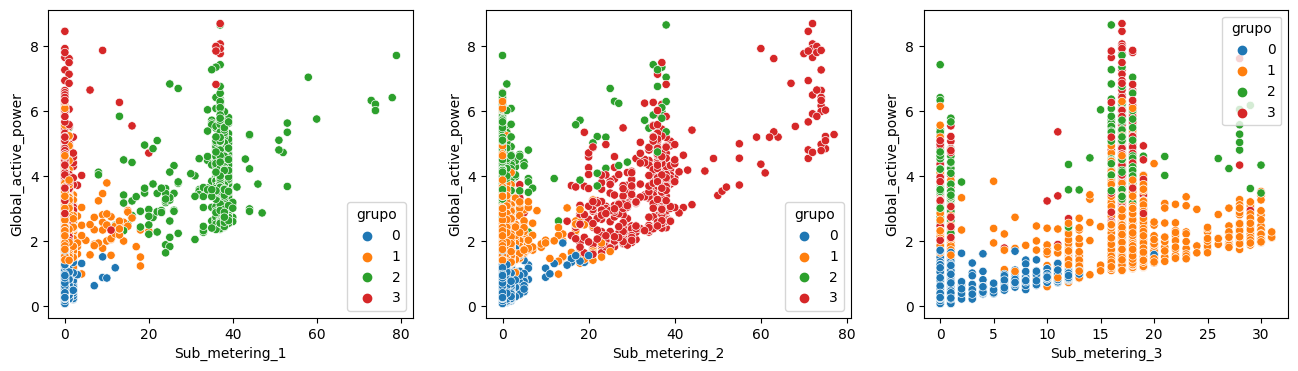

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.scatterplot(dados_amostra, y='Global_active_power', x='Sub_metering_1', hue='grupo', palette='tab10')
#plt.title('Global_active_power x Sub_metering_1')

plt.subplot(1,3,2)
sns.scatterplot(dados_amostra, y='Global_active_power', x='Sub_metering_2', hue='grupo', palette='tab10')
#plt.title('Global_active_power x Sub_metering_2')

plt.subplot(1,3,3)
sns.scatterplot(dados_amostra, y='Global_active_power', x='Sub_metering_3', hue='grupo', palette='tab10')
#plt.title('Global_active_power x Sub_metering_3')


In [134]:
dados_amostra.groupby('grupo').mean()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
grupo,,,,,,,
0,0.442242,0.115589,241.822709,1.932494,0.029712,0.396214,0.615556
1,1.843312,0.125853,239.636128,7.699605,0.192864,0.516742,16.364819
2,3.896030,0.209831,237.189888,16.534457,36.308989,2.307116,10.925094
3,3.697149,0.230960,237.660566,15.740881,0.897275,33.771488,10.811321
